# Data Preperation


In [1863]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

* To prevent data leakage, isolate the training dataset first.

In [1864]:
train_df = pd.read_csv('dataset/train.csv')
test_df = pd.read_csv('dataset/test.csv')

y = train_df["Survived"]
X = train_df.drop(["Survived"], axis=1)

X

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## Data Preprocessing
* Data cleaning
* Data transformation
* Data reduction

### Data Cleaning

#### Data Imputation
* The dataset is not large.
* Missing values are concentrated in the features `age` and `cabin`.

In [1865]:
print('\n[Train Data] Null Values\n{}'.format(train_df.isnull().sum()))
print('\n[Test Data] Null Values\n{}'.format(test_df.isnull().sum()))


[Train Data] Null Values
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

[Test Data] Null Values
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


* `Age`: Given the social nature of titles, I extract titles from names for filling missing values.

In [1866]:
train_df['Title'] = train_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
train_df = train_df.drop('Name', axis=1)
train_df['Title'].value_counts()

Title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: count, dtype: int64

In [1867]:
test_df['Title'] = test_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test_df = test_df.drop('Name', axis=1)
test_df['Title'].value_counts()

Title
Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Name: count, dtype: int64

* Strange values such as Mlle(French) are checked. Change them accordingly.
* Also, cases like Don's are too rare to be useful for age estimation. To avoid overfitting, replace a separate rare case with this one.

In [1868]:
title_mapping = {
    'Mlle': 'Miss',     
    'Ms': 'Miss',     
    'Mme': 'Mrs',   
    'Capt': 'Rare', 
    'Col': 'Rare',  
    'Major': 'Rare',
    'Dr': 'Rare',
    'Rev': 'Rare',
    'Don': 'Rare',
    'Dona': 'Rare',
    'Lady': 'Rare',
    'Sir': 'Rare',
    'Countess': 'Rare',
    'Jonkheer': 'Rare',
}
train_df['Title'] = train_df['Title'].replace(title_mapping)
train_df['Title'].value_counts()

Title
Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: count, dtype: int64

In [1869]:
test_df['Title'] = test_df['Title'].replace(title_mapping)
test_df['Title'].value_counts()

Title
Mr        240
Miss       79
Mrs        72
Master     21
Rare        6
Name: count, dtype: int64

In [1870]:
title_median = train_df.groupby('Title')['Age'].median()
train_df['Age'] = train_df['Age'].fillna(train_df['Title'].map(title_median))
title_median

Title
Master     3.5
Miss      21.0
Mr        30.0
Mrs       35.0
Rare      48.5
Name: Age, dtype: float64

In [1871]:
title_median = test_df.groupby('Title')['Age'].median()
test_df['Age'] = test_df['Age'].fillna(test_df['Title'].map(title_median))
title_median

Title
Master     7.0
Miss      22.0
Mr        28.5
Mrs       36.5
Rare      44.0
Name: Age, dtype: float64

* `cabin`: The ratio of 687/891 is missing, and the value itself doesn't seem to have much meaning. It would be better to replace it with a binary classification of 0(missing value) or 1.

In [1872]:
train_df['Has_Cabin'] = train_df['Cabin'].notnull().astype(int)
train_df = train_df.drop('Cabin', axis=1)

In [1873]:
test_df['Has_Cabin'] = test_df['Cabin'].notnull().astype(int)
test_df = test_df.drop('Cabin', axis=1)

* `Embarked`, `Fare`: Because the number of missing values is small, we replace them with the most frequent values.

In [1874]:
train_df['Embarked'].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [1875]:
train_df['Embarked'] = train_df['Embarked'].fillna('S')

In [1876]:
test_df['Fare'].value_counts()

Fare
7.7500     21
26.0000    19
13.0000    17
8.0500     17
7.8958     11
           ..
7.8208      1
8.5167      1
78.8500     1
52.0000     1
22.3583     1
Name: count, Length: 169, dtype: int64

In [1877]:
test_df['Fare'] = test_df['Fare'].fillna(7.7500)

In [1878]:
print('\n[Train Data] Null Values\n{}'.format(train_df.isnull().sum()))
print('\n[Test Data] Null Values\n{}'.format(test_df.isnull().sum()))


[Train Data] Null Values
PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Title          0
Has_Cabin      0
dtype: int64

[Test Data] Null Values
PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Title          0
Has_Cabin      0
dtype: int64


#### Duplicates/outliers

In [1879]:
print(f"Duplicates: {train_df.duplicated().sum()}")

Duplicates: 0


In [1880]:
print(f"Duplicates: {test_df.duplicated().sum()}")

Duplicates: 0


In [1881]:
import seaborn as sns
import matplotlib.pyplot as plt

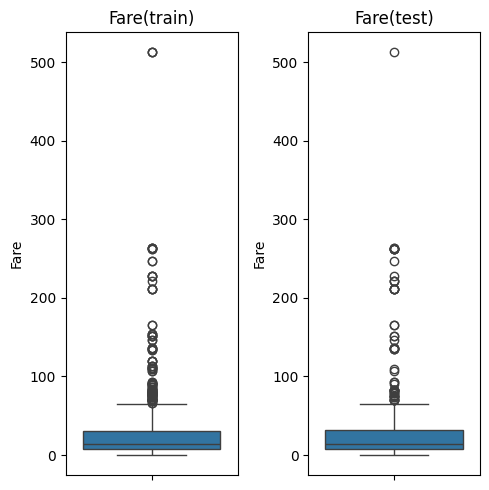

In [1882]:
plt.figure(figsize=(5,5))

plt.subplot(1, 2, 1)
sns.boxplot(y=train_df['Fare'])
plt.title('Fare(train)')

plt.subplot(1, 2, 2)
sns.boxplot(y=test_df['Fare'])
plt.title('Fare(test)')

plt.tight_layout()
plt.show()

In [1883]:
# upper_limit = train_df['Fare'].quantile(0.99)
# lower_limit = train_df['Fare'].quantile(0.01)

# train_df['Fare'] = train_df['Fare'].clip(lower=lower_limit, upper=upper_limit)

train_df['Fare'] = np.log1p(train_df['Fare'])
test_df['Fare'] = np.log1p(test_df['Fare'])

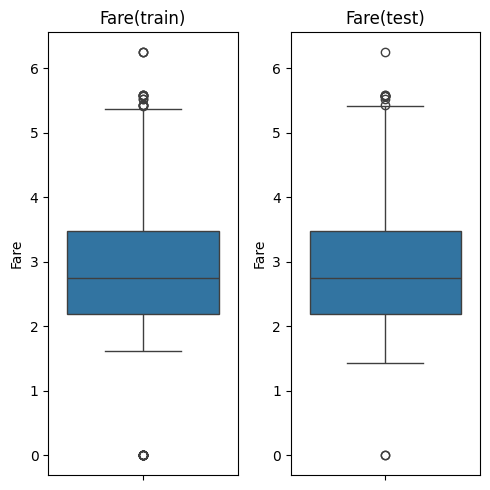

In [1884]:
plt.figure(figsize=(5,5))

plt.subplot(1, 2, 1)
sns.boxplot(y=train_df['Fare'])
plt.title('Fare(train)')

plt.subplot(1, 2, 2)
sns.boxplot(y=test_df['Fare'])
plt.title('Fare(test)')

plt.tight_layout()
plt.show()

### Data Transformation

In [1885]:
train_df['Sex'] = train_df['Sex'].map({'male':0, 'female':1})

embarked_map = {'S': 3, 'C': 2, 'Q': 1} 
train_df['Embarked'] = train_df['Embarked'].map(embarked_map)

title_order = {'Master':0, 'Miss':1, 'Mrs':2, 'Mr':3, 'Rare':4}
train_df['Title'] = train_df['Title'].map(title_order)

pclass_map = {1:3, 2:2, 3:1}  
train_df['Pclass'] = train_df['Pclass'].map(pclass_map)


train_df

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,Has_Cabin
0,1,0,1,0,22.0,1,0,A/5 21171,2.110213,3,3,0
1,2,1,3,1,38.0,1,0,PC 17599,4.280593,2,2,1
2,3,1,1,1,26.0,0,0,STON/O2. 3101282,2.188856,3,1,0
3,4,1,3,1,35.0,1,0,113803,3.990834,3,2,1
4,5,0,1,0,35.0,0,0,373450,2.202765,3,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,0,27.0,0,0,211536,2.639057,3,4,0
887,888,1,3,1,19.0,0,0,112053,3.433987,3,1,1
888,889,0,1,1,21.0,1,2,W./C. 6607,3.196630,3,1,0
889,890,1,3,0,26.0,0,0,111369,3.433987,2,3,1


In [1886]:
test_df['Sex'] = test_df['Sex'].map({'male':0, 'female':1})

embarked_map = {'S': 3, 'C': 2, 'Q': 1} 
test_df['Embarked'] = test_df['Embarked'].map(embarked_map)

title_order = {'Master':0, 'Miss':1, 'Mrs':2, 'Mr':3, 'Rare':4}
test_df['Title'] = test_df['Title'].map(title_order)

pclass_map = {1:3, 2:2, 3:1}  
test_df['Pclass'] = test_df['Pclass'].map(pclass_map)


test_df

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,Has_Cabin
0,892,1,0,34.5,0,0,330911,2.178064,1,3,0
1,893,1,1,47.0,1,0,363272,2.079442,3,2,0
2,894,2,0,62.0,0,0,240276,2.369075,1,3,0
3,895,1,0,27.0,0,0,315154,2.268252,3,3,0
4,896,1,1,22.0,1,1,3101298,2.586824,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,1,0,28.5,0,0,A.5. 3236,2.202765,3,3,0
414,1306,3,1,39.0,0,0,PC 17758,4.699571,2,4,1
415,1307,1,0,38.5,0,0,SOTON/O.Q. 3101262,2.110213,3,3,0
416,1308,1,0,28.5,0,0,359309,2.202765,3,3,0


### Data Reduction

In [1887]:
train_df = train_df.drop(['Ticket','PassengerId'], axis=1)
test_df = test_df.drop(['Ticket'], axis=1)


## Feature Engineering

In [1888]:
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1
train_df['IsAlone'] = (train_df['FamilySize'] == 1).astype(int)

In [1889]:
test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch'] + 1
test_df['IsAlone'] = (test_df['FamilySize'] == 1).astype(int)

In [1890]:
X = train_df.drop(["Survived"], axis=1)
X

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Has_Cabin,FamilySize,IsAlone
0,1,0,22.0,1,0,2.110213,3,3,0,2,0
1,3,1,38.0,1,0,4.280593,2,2,1,2,0
2,1,1,26.0,0,0,2.188856,3,1,0,1,1
3,3,1,35.0,1,0,3.990834,3,2,1,2,0
4,1,0,35.0,0,0,2.202765,3,3,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
886,2,0,27.0,0,0,2.639057,3,4,0,1,1
887,3,1,19.0,0,0,3.433987,3,1,1,1,1
888,1,1,21.0,1,2,3.196630,3,1,0,4,0
889,3,0,26.0,0,0,3.433987,2,3,1,1,1


In [1891]:
from sklearn.ensemble import RandomForestClassifier

y = train_df["Survived"]
X = train_df.drop(["Survived"], axis=1)

model = RandomForestClassifier()
model.fit(X, y)


RandomForestClassifier()

In [1892]:
imp_score=model.feature_importances_
top_indices=np.argsort(imp_score)[::-1][:5]
print(top_indices)
top_feature_names=[X.columns[int(x)] for x in top_indices]
print(top_feature_names)

[5 2 7 1 0]
['Fare', 'Age', 'Title', 'Sex', 'Pclass']


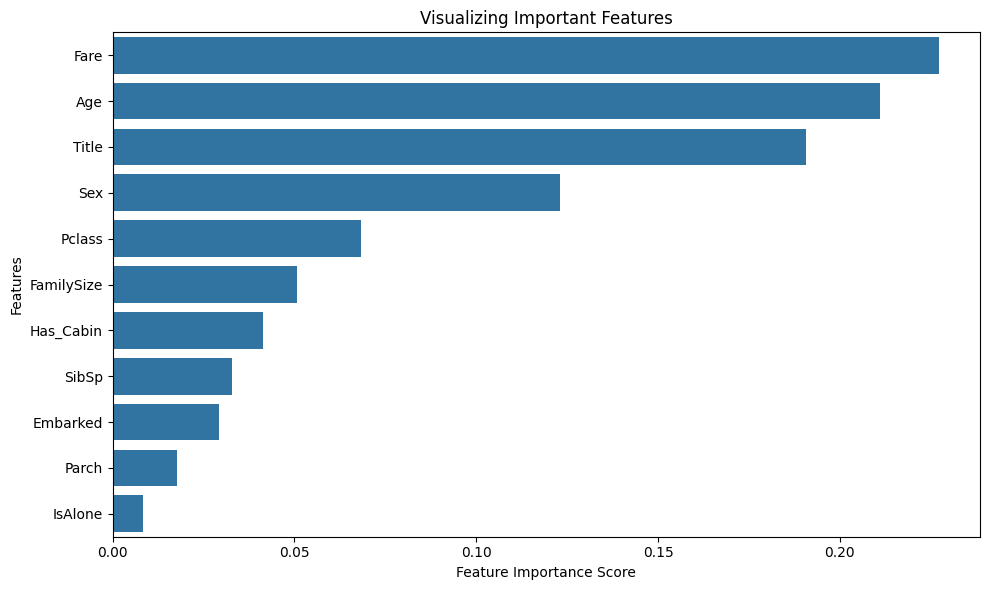

In [1893]:
feature_imp = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.tight_layout() 

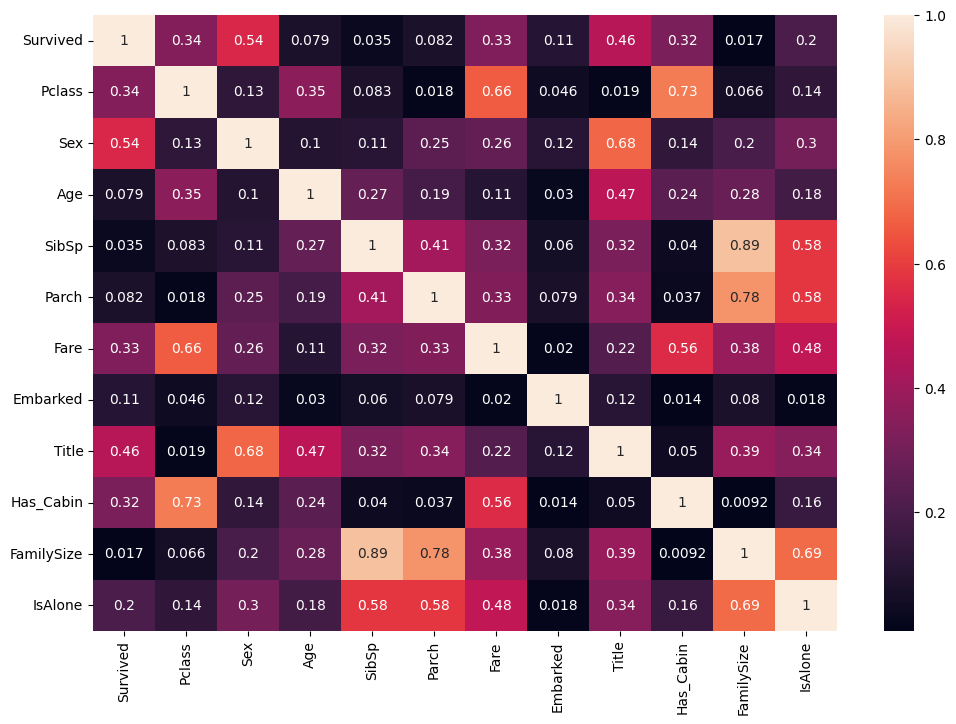

In [1894]:
corr_matrix = train_df.corr().abs()

plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True)
plt.show()

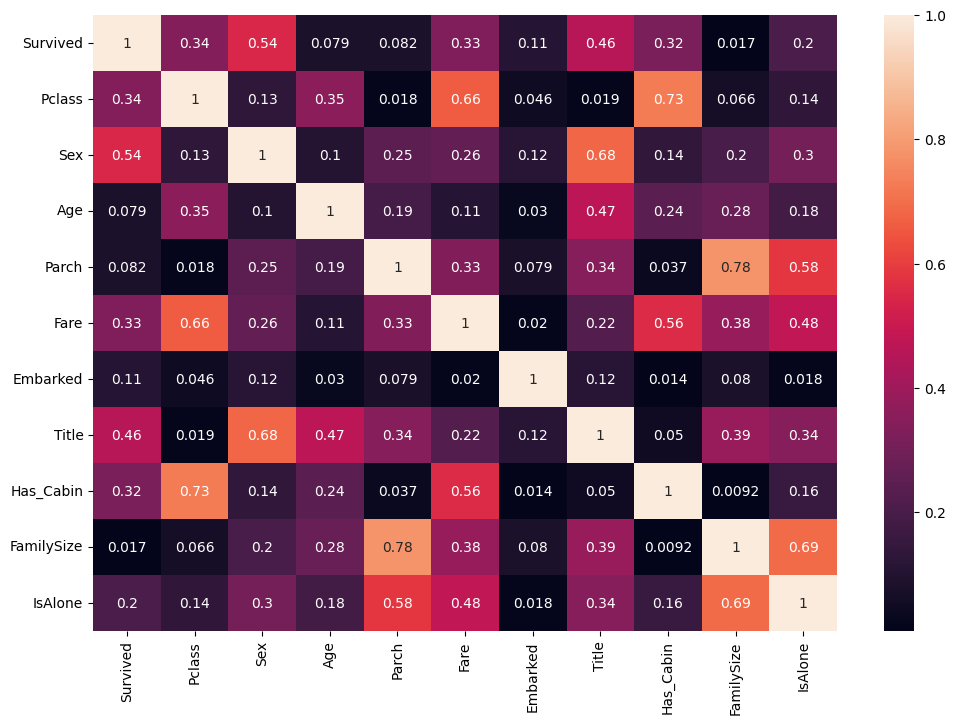

In [1895]:
train_df = train_df.drop('SibSp', axis=1)
test_df = test_df.drop('SibSp', axis=1)
corr_matrix = train_df.corr().abs()

plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True)
plt.show()

# Model

* My decision to use a tree structure was based on the small size of the dataset, its structured structure, the presence of non-linear interactions, and the large number of categorical variables.
* I chose to use Catboost because I had poor feature engineering and a lot of categorical variables.

In [1896]:
# Reverse the value to focus on the dead person's case
train_df['Survived'] = 1 - train_df['Survived']

In [1897]:
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (log_loss, roc_auc_score, f1_score, 
                             accuracy_score, precision_score, 
                             recall_score, matthews_corrcoef,
                             confusion_matrix)

y = train_df["Survived"]
X = train_df.drop(["Survived"], axis=1)

cat_features=['Pclass', 'Sex','Parch', 'Title', 'Has_Cabin', 'Embarked', 'IsAlone'] 

model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.2,
    depth=4,
    rsm=0.7,
    loss_function='Logloss',
    eval_metric='Logloss',
    thread_count=-1,
    verbose=0,
    allow_writing_files=False,
    cat_features=cat_features
)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
metrics = []

for train_idx, val_idx in skf.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model.fit(X_train, y_train)
    
    pred_proba = model.predict_proba(X_val)[:,1]
    pred = (pred_proba >= 0.475019).astype(int)
    
    metrics.append({
        'logloss': log_loss(y_val, pred_proba),
        'auc': roc_auc_score(y_val, pred_proba),
        'f1': f1_score(y_val, pred),
        'accuracy': accuracy_score(y_val, pred),
        'precision': precision_score(y_val, pred),
        'recall': recall_score(y_val, pred),
        'mcc': matthews_corrcoef(y_val, pred)
    })

final_metrics = pd.DataFrame(metrics).mean()

conf_matrix = confusion_matrix(y_val, pred)
print(f"\nConfusion Matrix:\n{conf_matrix}")
print(f"\nFinal Metrics:\n{final_metrics}")


Confusion Matrix:
[[25 10]
 [ 5 49]]

Final Metrics:
logloss      0.491919
auc          0.875449
f1           0.861852
accuracy     0.824856
precision    0.841349
recall       0.885286
mcc          0.626953
dtype: float64


# Evaluation


In [ ]:
model.fit(X, y)  

X_test = test_df[X.columns]  

pred_proba_test = model.predict_proba(X_test)[:, 1]
test_preds = (pred_proba_test >= 0.475019).astype(int)
test_preds = 1-test_preds

test_df['Survived_Pred'] = test_preds

submission = test_df[['PassengerId']].copy()
submission['Survived'] = test_preds


submission.to_csv("dataset/prediction.csv", index=False)

              precision    recall  f1-score   support

     Dead(0)       0.88      0.89      0.88       266
 Survived(1)       0.80      0.78      0.79       152

    accuracy                           0.85       418
   macro avg       0.84      0.84      0.84       418
weighted avg       0.85      0.85      0.85       418



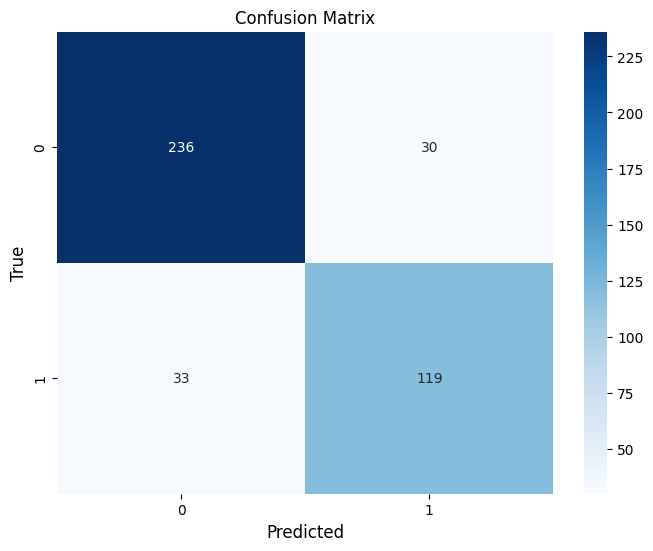


--------------------------------------------------
Accuracy: 0.8493
Precision: 0.7987
Recall: 0.7829
F1-Score: 0.7907
ROC AUC: 0.8351


In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report,
    roc_auc_score
)

ground_truth = pd.read_csv('dataset/gender_submission.csv')  # 실제 정답
predictions = pd.read_csv('dataset/prediction.csv')  # 모델 예측 결과

# 2. 데이터 병합 (PassengerId 기준)
merged = pd.merge(ground_truth, predictions, on='PassengerId', suffixes=('_true', '_pred'))

# 3. 평가 지표 계산
y_true = merged['Survived_true']
y_pred = merged['Survived_pred']

# 기본 평가 지표
print(classification_report(y_true, y_pred, target_names=['Dead(0)', 'Survived(1)']))

# 혼동 행렬 시각화
plt.figure(figsize=(8,6))
cm = sns.heatmap(confusion_matrix(y_true, y_pred), 
            annot=True, fmt=',d', cmap='Blues')
cm.set_xlabel('Predicted', fontsize=12)
cm.set_ylabel('True', fontsize=12)
plt.title('Confusion Matrix')
plt.show()

# 추가 지표 계산
metrics = {
    'Accuracy': accuracy_score(y_true, y_pred),
    'Precision': precision_score(y_true, y_pred),
    'Recall': recall_score(y_true, y_pred),
    'F1-Score': f1_score(y_true, y_pred),
    'ROC AUC': roc_auc_score(y_true, y_pred)
}

print("\n" + "-"*50)
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")